
# Geo Analytics: Platform Virality & Hashtag Popularity by Country

This notebook builds two geo analyses from your dataset:

1. **Platform virality by country** — which platform has the highest engagement (average `Engagement_Rate`) in each country.
2. **Top hashtag by country** — most-used (or most-engaged) hashtag in each country.

It also includes:
- A **choropleth** map colored by dominant platform.
- A **bubble (Dorling-style) cartogram** sized by engagement.
- *(Optional)* a true **area cartogram** if `geopandas`/`geoplot` are installed.


## 0) Setup & (optional) installs

In [23]:

# If these are missing in your environment, uncomment to install:
# !pip install plotly pandas numpy geopandas geoplot pycountry

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

# Optional (for true cartograms)
try:
    import geopandas as gpd
    import geoplot as gplt
    import matplotlib.pyplot as plt
    HAVE_GEO = True
except Exception:
    HAVE_GEO = False
    print("[Note] 'geopandas' / 'geoplot' not available. Bubble cartogram will be used; true area cartogram skipped.")


[Note] 'geopandas' / 'geoplot' not available. Bubble cartogram will be used; true area cartogram skipped.


## 1) Load your data

In [24]:

CSV_PATH = "Cleaned_Viral_Social_Media_Trends.csv"  # adjust if needed
DATE_COL = "Post_Date"
COUNTRY_COL = "Region"
PLATFORM_COL = "Platform"
HASHTAG_COL = "Hashtag"

df = pd.read_csv(CSV_PATH)

if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

print("Rows:", len(df))
df.head()


Rows: 5000


,Post_ID,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
0,Post_1,2022-01-13,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High
1,Post_2,2022-05-13,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium
2,Post_3,2022-01-07,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium
3,Post_4,2022-12-05,YouTube,#Education,Shorts,Australia,917951,127125,11687,36806,Low
4,Post_5,2023-03-23,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium


## 2) Clean columns & compute engagement metrics

In [25]:

for c in ["Views","Likes","Shares","Comments"]:
    if c not in df.columns:
        df[c] = 0
for c in ["Views","Likes","Shares","Comments"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

if "Engagement_Rate" not in df.columns:
    df["Engagement_Rate"] = (df["Likes"].fillna(0) + df["Shares"].fillna(0) + df["Comments"].fillna(0)) / (
        df["Views"].replace(0, np.nan)
    )
    df["Engagement_Rate"] = df["Engagement_Rate"].fillna(0.0)

df["Total_Engagement"] = df["Likes"].fillna(0) + df["Shares"].fillna(0) + df["Comments"].fillna(0)

replace_map = {
    "USA": "United States",
    "US": "United States",
    "United States of America": "United States",
    "UK": "United Kingdom",
    "Korea": "South Korea",
    "UAE": "United Arab Emirates",
    "Russia": "Russian Federation",
    "Viet Nam": "Vietnam",
    "Hongkong": "Hong Kong"
}
if "Region" in df.columns:
    df["Region"] = df["Region"].astype(str).str.strip().replace(replace_map)

df[[COUNTRY_COL, PLATFORM_COL, "Engagement_Rate", "Total_Engagement"]].head(5)


,Region,Platform,Engagement_Rate,Total_Engagement
0,United Kingdom,TikTok,0.098935,411912
1,India,Instagram,0.074192,308339
2,Brazil,Twitter,0.109865,402789
3,Australia,YouTube,0.191315,175618
4,Brazil,TikTok,3.812752,247318


## 3) Platform virality by country (dominant platform via average Engagement_Rate)

In [26]:

plat_gp = (
    df.groupby([COUNTRY_COL, PLATFORM_COL], as_index=False)["Engagement_Rate"]
      .mean()
      .rename(columns={"Engagement_Rate":"Avg_Engagement_Rate"})
)

idx = plat_gp.groupby(COUNTRY_COL)["Avg_Engagement_Rate"].idxmax()
dominant_plat = plat_gp.loc[idx].reset_index(drop=True)
dominant_plat.head(10)


,Region,Platform,Avg_Engagement_Rate
0,Australia,Instagram,0.885095
1,Brazil,Instagram,0.873873
2,Canada,Instagram,0.749620
3,Germany,YouTube,0.521709
4,India,Twitter,0.964067
5,Japan,Instagram,1.238250
6,United Kingdom,YouTube,0.712379
7,United States,TikTok,2.419051


### 3a) Choropleth — color by dominant platform

In [27]:

d_plot = dominant_plat[dominant_plat[COUNTRY_COL].notna()].copy()

fig = px.choropleth(
    d_plot,
    locations=COUNTRY_COL,
    locationmode="country names",
    color=PLATFORM_COL,
    hover_name=COUNTRY_COL,
    hover_data={"Avg_Engagement_Rate":":.4f"},
    title="Dominant Platform by Country (highest Avg Engagement Rate)"
)
fig.update_geos(showcountries=True, projection_type="natural earth")
fig.show()


### 3b) Bubble (Dorling-style) cartogram — size by total engagement volume

In [28]:

country_eng = (
    df.groupby(COUNTRY_COL, as_index=False)["Total_Engagement"]
      .sum()
      .rename(columns={"Total_Engagement":"Engagement_Volume"})
)

fig = px.scatter_geo(
    country_eng,
    locations=COUNTRY_COL,
    locationmode="country names",
    size="Engagement_Volume",
    hover_name=COUNTRY_COL,
    title="Bubble Cartogram — Country sized by Total Engagement",
    size_max=40
)
fig.update_geos(showcountries=True, projection_type="natural earth")
fig.show()


In [10]:
!pip install git+https://github.com/martinfleis/cartogram.git

  Cloning https://github.com/martinfleis/cartogram.git to /private/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/pip-req-build-8cgj6ah_
  Running command git clone --filter=blob:none --quiet https://github.com/martinfleis/cartogram.git /private/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/pip-req-build-8cgj6ah_
  remote: Repository not found.
  fatal: repository 'https://github.com/martinfleis/cartogram.git/' not found
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/martinfleis/cartogram.git /private/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/pip-req-build-8cgj6ah_ did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/martinfleis/cartogram.git /private/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/pip-req-build-8cgj6ah_ d

### 3c) (Optional) True area cartogram (requires geopandas + geoplot)

In [9]:
import cartogram, geopandas as gpd, matplotlib.pyplot as plt, pandas as pd, numpy as np

# Load data and aggregate by country
df = pd.read_csv("Cleaned_Viral_Social_Media_Trends.csv")
for c in ["Views","Likes","Shares","Comments"]:
    if c not in df: df[c] = 0
df["Total_Engagement"] = df[["Likes","Shares","Comments"]].sum(axis=1)
country_eng = df.groupby("Region",as_index=False)["Total_Engagement"].sum()

# Load world countries
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
world = world.rename(columns={"ADMIN":"Region"})
gdf = world.merge(country_eng,on="Region",how="left").fillna({"Total_Engagement":0})

# Generate area-distorted cartogram
carto = cartogram.cartogram(gdf, "Total_Engagement", iterations=5)

fig, ax = plt.subplots(figsize=(13,7))
carto.plot(column="Total_Engagement", cmap="viridis", legend=True, ax=ax)
ax.set_title("True Area Cartogram — Country Area ∝ Total Engagement")
plt.show()

ModuleNotFoundError: No module named 'cartogram'

## 4) Top hashtag by country

In [14]:

if HASHTAG_COL in df.columns:
    tags = df[[COUNTRY_COL, HASHTAG_COL, "Total_Engagement"]].dropna(subset=[HASHTAG_COL]).copy()
    tags[HASHTAG_COL] = (tags[HASHTAG_COL].astype(str)
                         .str.lower()
                         .str.replace(" ", "", regex=False))
    tags = tags.assign(**{HASHTAG_COL: tags[HASHTAG_COL].str.split(",")}).explode(HASHTAG_COL)
    tags[HASHTAG_COL] = tags[HASHTAG_COL].str.replace("^#+", "", regex=True)
    tags = tags[tags[HASHTAG_COL] != ""]

    tag_count = (tags.groupby([COUNTRY_COL, HASHTAG_COL], as_index=False)
                      .size()
                      .rename(columns={"size":"Tag_Count"}))
    idx_cnt = tag_count.groupby(COUNTRY_COL)["Tag_Count"].idxmax()
    top_tag_count = tag_count.loc[idx_cnt].reset_index(drop=True)

    tag_eng = (tags.groupby([COUNTRY_COL, HASHTAG_COL], as_index=False)["Total_Engagement"]
                    .sum()
                    .rename(columns={"Total_Engagement":"Tag_Engagement"}))
    idx_eng = tag_eng.groupby(COUNTRY_COL)["Tag_Engagement"].idxmax()
    top_tag_eng = tag_eng.loc[idx_eng].reset_index(drop=True)

    display(top_tag_count.head(10))
    display(top_tag_eng.head(10))
else:
    print("No Hashtag column found.")


,Region,Hashtag,Tag_Count
0,Australia,fitness,81
1,Brazil,education,74
2,Canada,education,78
3,Germany,tech,63
4,India,gaming,82
5,Japan,education,77
6,United Kingdom,comedy,83
7,United States,fitness,79


,Region,Hashtag,Tag_Engagement
0,Australia,fitness,28059269
1,Brazil,education,24634491
2,Canada,education,26346542
3,Germany,fashion,19813950
4,India,gaming,26137832
5,Japan,education,25418078
6,United Kingdom,comedy,26381468
7,United States,fitness,26119641


### 4a) Label map — top hashtag by count

In [17]:

if 'top_tag_count' in locals():
    fig = px.choropleth(
        top_tag_count,
        locations=COUNTRY_COL,
        locationmode="country names",
        color="Tag_Count",
        color_continuous_scale="Viridis",
        hover_name=COUNTRY_COL,
        title="Top Hashtag by Country (shaded by frequency)"
    )
    fig_scatter = px.scatter_geo(
        top_tag_count,
        locations=COUNTRY_COL,
        locationmode="country names",
        text=HASHTAG_COL,
    )
    for tr in fig_scatter.data:
        tr.marker.update(size=0)
        tr.textposition = "middle center"
        fig.add_trace(tr)
    for tr in fig.data:
        if tr.type == "scattergeo":
            tr.textfont = dict(size=9)
    fig.update_geos(showcountries=True, projection_type="natural earth")
    fig.show()
else:
    print("Skipping label map — no top_tag_count computed.")


### 4b) Label map — top hashtag by engagement

In [20]:

if 'top_tag_eng' in locals():
    fig = px.choropleth(
        top_tag_eng,
        locations=COUNTRY_COL,
        locationmode="country names",
        color="Tag_Engagement",
        color_continuous_scale="Plasma",
        hover_name=COUNTRY_COL,
        title="Top Hashtag by Country (shaded by total engagement)"
    )
    fig_scatter = px.scatter_geo(
        top_tag_eng,
        locations=COUNTRY_COL,
        locationmode="country names",
        text=HASHTAG_COL,
    )
    for tr in fig_scatter.data:
        tr.marker.update(size=0)
        tr.textposition = "middle center"
        fig.add_trace(tr)
    for tr in fig.data:
        if tr.type == "scattergeo":
            tr.textfont = dict(size=9)
    fig.update_geos(showcountries=True, projection_type="natural earth")
    fig.show()
else:
    print("Skipping label map — no top_tag_eng computed.")


In [11]:
import pandas as pd, numpy as np, plotly.express as px

# --- Load and prepare ---
df = pd.read_csv("Cleaned_Viral_Social_Media_Trends.csv")
for c in ["Views","Likes","Shares","Comments"]:
    if c not in df: df[c] = 0

df["Total_Engagement"] = df[["Likes","Shares","Comments"]].sum(axis=1)
df["Engagement_Rate"] = (
    df["Total_Engagement"] / df["Views"].replace(0, np.nan)
).fillna(0)

COUNTRY_COL = "Region"

# --- Aggregate by country ---
country_summary = (
    df.groupby(COUNTRY_COL, as_index=False)
    .agg(
        Avg_Engagement_Rate=("Engagement_Rate","mean"),
        Total_Engagement=("Total_Engagement","sum"),
        Post_Count=("Post_ID","count")
    )
)

# --- Plot heatmap (choropleth) ---
fig = px.choropleth(
    country_summary,
    locations=COUNTRY_COL,
    locationmode="country names",
    color="Avg_Engagement_Rate",   # you can also use "Total_Engagement"
    hover_name=COUNTRY_COL,
    hover_data={"Total_Engagement":":,.0f", "Post_Count": True},
    color_continuous_scale="YlOrRd",
    title="🌎 Heatmap of Average Engagement Rate by Country"
)

fig.update_geos(showcountries=True, projection_type="natural earth")
fig.update_layout(coloraxis_colorbar_title="Engagement Rate")
fig.show()

/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_63423/3014531147.py:26: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [13]:
import pandas as pd, numpy as np, plotly.express as px

df = pd.read_csv("Cleaned_Viral_Social_Media_Trends.csv")
for c in ["Views","Likes","Shares","Comments"]:
    if c not in df: df[c] = 0
df["Total_Engagement"] = df[["Likes","Shares","Comments"]].sum(axis=1)
df["Engagement_Rate"] = (df["Total_Engagement"]/df["Views"].replace(0,np.nan)).fillna(0)

df["Post_Date"] = pd.to_datetime(df["Post_Date"], errors="coerce")
df = df.dropna(subset=["Post_Date"])
df["Month"] = df["Post_Date"].dt.to_period("M").astype(str)

# --- Aggregate per Region × Platform × Month ---
agg = (df.groupby(["Region","Platform","Month"],as_index=False)
         .agg(Avg_Rate=("Engagement_Rate","mean"),
              Total_Engagement=("Total_Engagement","sum"),
              Posts=("Post_ID","count")))

# --- Animated map ---
fig = px.choropleth(
    agg,
    locations="Region",
    locationmode="country names",
    color="Avg_Rate",
    animation_frame="Month",
    facet_col="Platform",            # one panel per platform
    color_continuous_scale="YlOrRd",
    hover_name="Region",
    hover_data={"Total_Engagement":":,.0f","Posts":True},
    title="🌍 Monthly Engagement Heatmap by Platform"
)

fig.update_geos(showcountries=True, projection_type="natural earth")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  # clean facet titles
fig.update_layout(coloraxis_colorbar_title="Avg Engagement Rate")
fig.show()

/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_63423/1475802966.py:20: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [14]:
import re
df_h = df.copy()
df_h["Hashtag"] = df_h["Hashtag"].astype(str).str.replace("#","")
df_h["Hashtag"] = df_h["Hashtag"].apply(lambda x: re.split("[, ]+", x))
df_h = df_h.explode("Hashtag").dropna(subset=["Hashtag"])

agg_h = (df_h.groupby(["Region","Hashtag","Month"],as_index=False)
            .agg(Avg_Rate=("Engagement_Rate","mean"),
                 Total_Engagement=("Total_Engagement","sum"),
                 Posts=("Post_ID","count")))

# Pick top N hashtags globally to animate
top_tags = agg_h.groupby("Hashtag")["Total_Engagement"].sum().nlargest(5).index
agg_top = agg_h[agg_h["Hashtag"].isin(top_tags)]

fig = px.choropleth(
    agg_top,
    locations="Region",
    locationmode="country names",
    color="Avg_Rate",
    animation_frame="Month",
    facet_col="Hashtag",             # one panel per top hashtag
    color_continuous_scale="YlGnBu",
    hover_name="Region",
    hover_data={"Total_Engagement":":,.0f","Posts":True},
    title="🌍 Monthly Viral Heatmap by Hashtag"
)
fig.update_geos(showcountries=True, projection_type="natural earth")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(coloraxis_colorbar_title="Avg Engagement Rate")
fig.show()

/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_63423/3587768368.py:16: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_63423/3999024339.py:45: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/MATH446/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



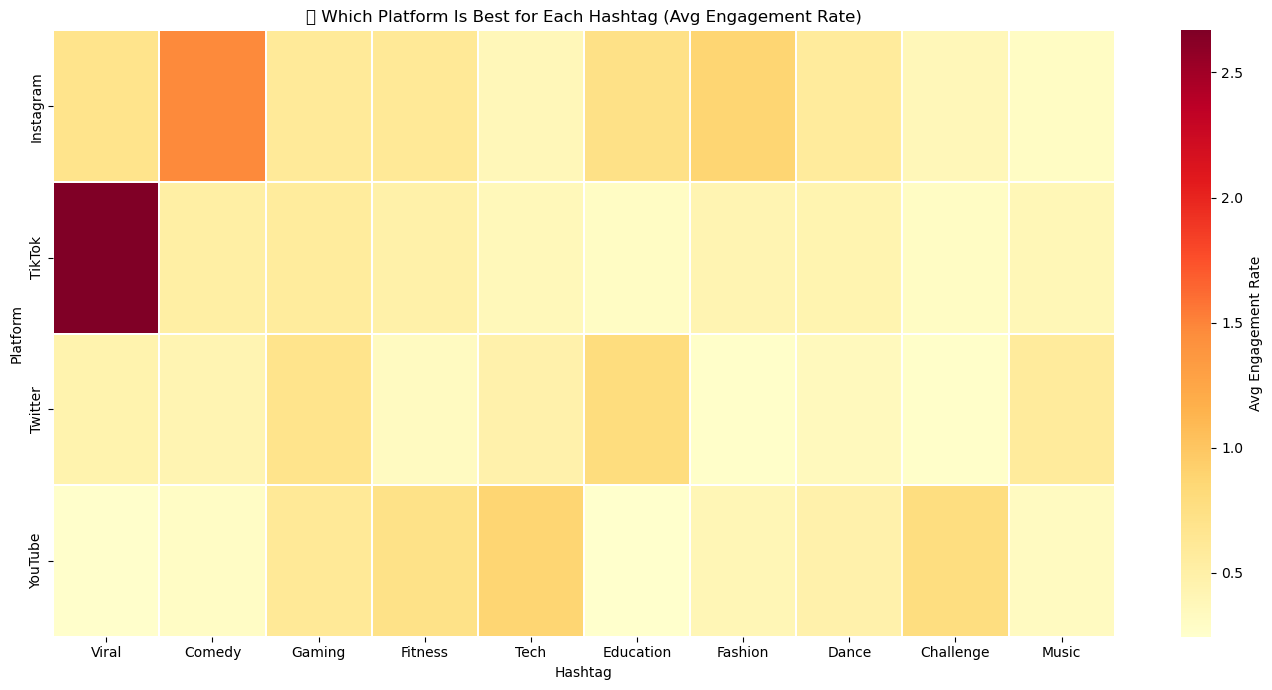

In [16]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# --- Prepare base data ---
df = pd.read_csv("Cleaned_Viral_Social_Media_Trends.csv")
for c in ["Views","Likes","Shares","Comments"]:
    if c not in df: df[c] = 0
df["Total_Engagement"] = df[["Likes","Shares","Comments"]].sum(axis=1)
df["Engagement_Rate"] = (df["Total_Engagement"]/df["Views"].replace(0,np.nan)).fillna(0)

# --- Split multiple hashtags ---
df["Hashtag"] = (
    df["Hashtag"].astype(str)
      .str.replace("#","")
      .str.split("[, ]+")
)
df = df.explode("Hashtag").dropna(subset=["Hashtag"])

# --- Compute average engagement per Platform × Hashtag ---
pivot = (
    df.groupby(["Platform","Hashtag"])["Engagement_Rate"]
      .mean()
      .unstack(fill_value=0)
)

# --- Focus on top hashtags globally ---
top_tags = (
    df.groupby("Hashtag")["Engagement_Rate"]
      .mean()
      .nlargest(20)
      .index
)
pivot_top = pivot[top_tags]

# --- Heatmap ---
plt.figure(figsize=(14,7))
sns.heatmap(
    pivot_top,
    cmap="YlOrRd",
    linewidths=0.3,
    cbar_kws={"label":"Avg Engagement Rate"}
)
plt.title("🔥 Which Platform Is Best for Each Hashtag (Avg Engagement Rate)")
plt.xlabel("Hashtag")
plt.ylabel("Platform")
plt.tight_layout()
plt.show()

best_platform = pivot.idxmax(axis=0)
result = best_platform.reset_index()
result.columns = ["Hashtag","Best_Platform"]
result.head(10)

geo_perf = (
    df.groupby(["Region","Platform","Hashtag"])
      .agg(Avg_Rate=("Engagement_Rate","mean"))
      .reset_index()
)

import plotly.express as px
fig = px.treemap(
    geo_perf,
    path=["Platform","Hashtag"],
    values="Avg_Rate",
    color="Avg_Rate",
    color_continuous_scale="YlOrRd",
    title="🌐 Platform–Hashtag Viral Strength"
)
fig.show()